In [6]:
# Importing necessary libraries

!pip install cellpylib

import cellpylib as cpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import seaborn as sns
import time
import math
import matplotlib.cm as cm # For colourmap plots later
from tqdm import tqdm # for a progress bar

In [ ]:
# Data generation parameters
data_size = 100 # the number of data points in each row of data
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

# Correlation evaluation parameters
sample_number = 30 #Too large. Calculations indicated that this run alone would take 67 hours. Will have to wait until the compute cluster is available

In [52]:
def find_correlation(sample_number, data_size, timesteps):

    # such that all programmes are selected from randomly
    programmes = np.arange(0, 256, 1)
    programmes_prob_distribution = np.full(256, 1/256, dtype='float')
    # initisalising the data and rule storage arrays
    data_array = np.zeros((sample_number, data_size))
    rule_number_array = np.zeros(sample_number, dtype = int)
    # creating the random data over which correlations may be calculated
    for i in tqdm(range(sample_number)):
        rule_number = np.random.choice(a = programmes, size=None, replace=True, p = programmes_prob_distribution)
        #print(f"Considering rule_number = ", rule_number)
        cellular_automaton = cpl.init_random(data_size)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
        data_array[i] = cellular_automaton[-1]
        rule_number_array[i] = rule_number
    # initisalising the correlation matrix. Note that this should be symmetric, and stores swap distance
    correlation_matrix = np.zeros((256, 256))
    # iterating over all rule number pairs
    for i, elem1 in tqdm(enumerate(rule_number_array)):
        for j, elem2 in enumerate(rule_number_array):
            data1 = data_array[i]
            data2 = data_array[j]
            dist = sum(x == y for x, y in zip(data1, data2)) #finds the swap distance
            
            correlation_matrix[elem1][elem2] = dist
    
    #with np.printoptions(threshold=np.inf):
        #print(correlation_matrix)

    return data_array, rule_number_array, correlation_matrix

In [ ]:
data_array, rule_number_array, correlation_matrix = find_correlation(sample_number, data_size, time_steps)
#print(data_array)
#print(rule_number_array)

In [ ]:
with np.printoptions(threshold=np.inf):
    print(correlation_matrix)

In [ ]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 22})
plt.title('Correlation matrix of elementary cellular automata programmes')
ax.matshow(correlation_matrix, cmap=plt.cm.Blues)

In [123]:
# NOT OPERATIONAL

# has the exact same outputs as find_correlation(), but does so by producing data when it is needed. Lighter on RAM

# NOTE: Important issue. Each run currently simply overwrites rather than performs an average. This is not good.

def find_corr_2(sample_number, data_size, time_steps):

    correlation_matrix = np.zeros((256,256))
    rule_number_array = np.zeros((sample_number, 2))
    for i in tqdm(range(sample_number)):
        last_row = []
        rule_numbers = []
        for j in range(2):
            rule_number = np.random.randint(0, 256)
            cellular_automaton = cpl.init_random(data_size)
            cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
            last_row.append(cellular_automaton[-1])
            rule_numbers.append(rule_number)

        corr = sum(x == y for x, y in zip(last_row[0], last_row[1]))
        correlation_matrix[rule_numbers[0], rule_numbers[1]] += corr
        rule_number_array[i] = rule_numbers
    # performing averaging, so that each run does not simply add to the correlation matrix
    # calculating the number of times a given pair has appeared in the set
    pair_counts = {}
    for pair in rule_number_array:
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1
    
    for pair in rule_number_array:
        count = pair_counts[pair] #number of times that pair has appeared in the rule_number_array
        correlation_matrix[pair[0], pair[1]] = correlation_matrix[pair[0], pair[1]] / count
    
    return rule_number_array, correlation_matrix

In [ ]:
rule_number_array, correlation_matrix = find_corr_2(100, 100, 100)

In [ ]:
with np.printoptions(threshold=np.inf):
    print(correlation_matrix)

In [ ]:
print(sum(x != 0 for x in correlation_matrix))

In [ ]:
print(np.where(x != 0 for x in np.diagonal(correlation_matrix)))

In [96]:
# Try calculating correlation slightly more intelligently. Not random this time

def find_corr_3(sample_number, data_size, timesteps): #here, sample number refers to the number of samples per pair

    correlation_matrix = np.zeros((256,256))
    # specifies the first rule number, i
    for i in tqdm(range(256)):
        # specifies the second rule number, j, which is geq i
        for j in range(i, 256):
            # specifies the point in the loop regarding sample number
            for k in range(sample_number):
                # will be written to with the two last rows
                last_row = []
                cellular_automaton = cpl.init_random(data_size)
                cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, i))
                last_row.append(cellular_automaton[-1])
                cellular_automaton = cpl.init_random(data_size)
                cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, j))
                last_row.append(cellular_automaton[-1])
                # calculate the correlation between these two last rows
                corr = sum(x == y for x, y in zip(last_row[0], last_row[1]))
                # adding this value to the array
                correlation_matrix[i][j] += corr
            #finding the average correlation values, because otherwise this is only being added to
            correlation_matrix[i][j] = correlation_matrix[i][j] / sample_number
            # because the matrix should be diagonal given the abelian nature of the variables
            correlation_matrix[j][i] = correlation_matrix[i][j]
            #print(correlation_matrix[i][j])

    return correlation_matrix

In [97]:
correlation_matrix = find_corr_3(sample_number=100, data_size=100, timesteps=100)

100%|██████████| 256/256 [24:35:19<00:00, 345.78s/it]    


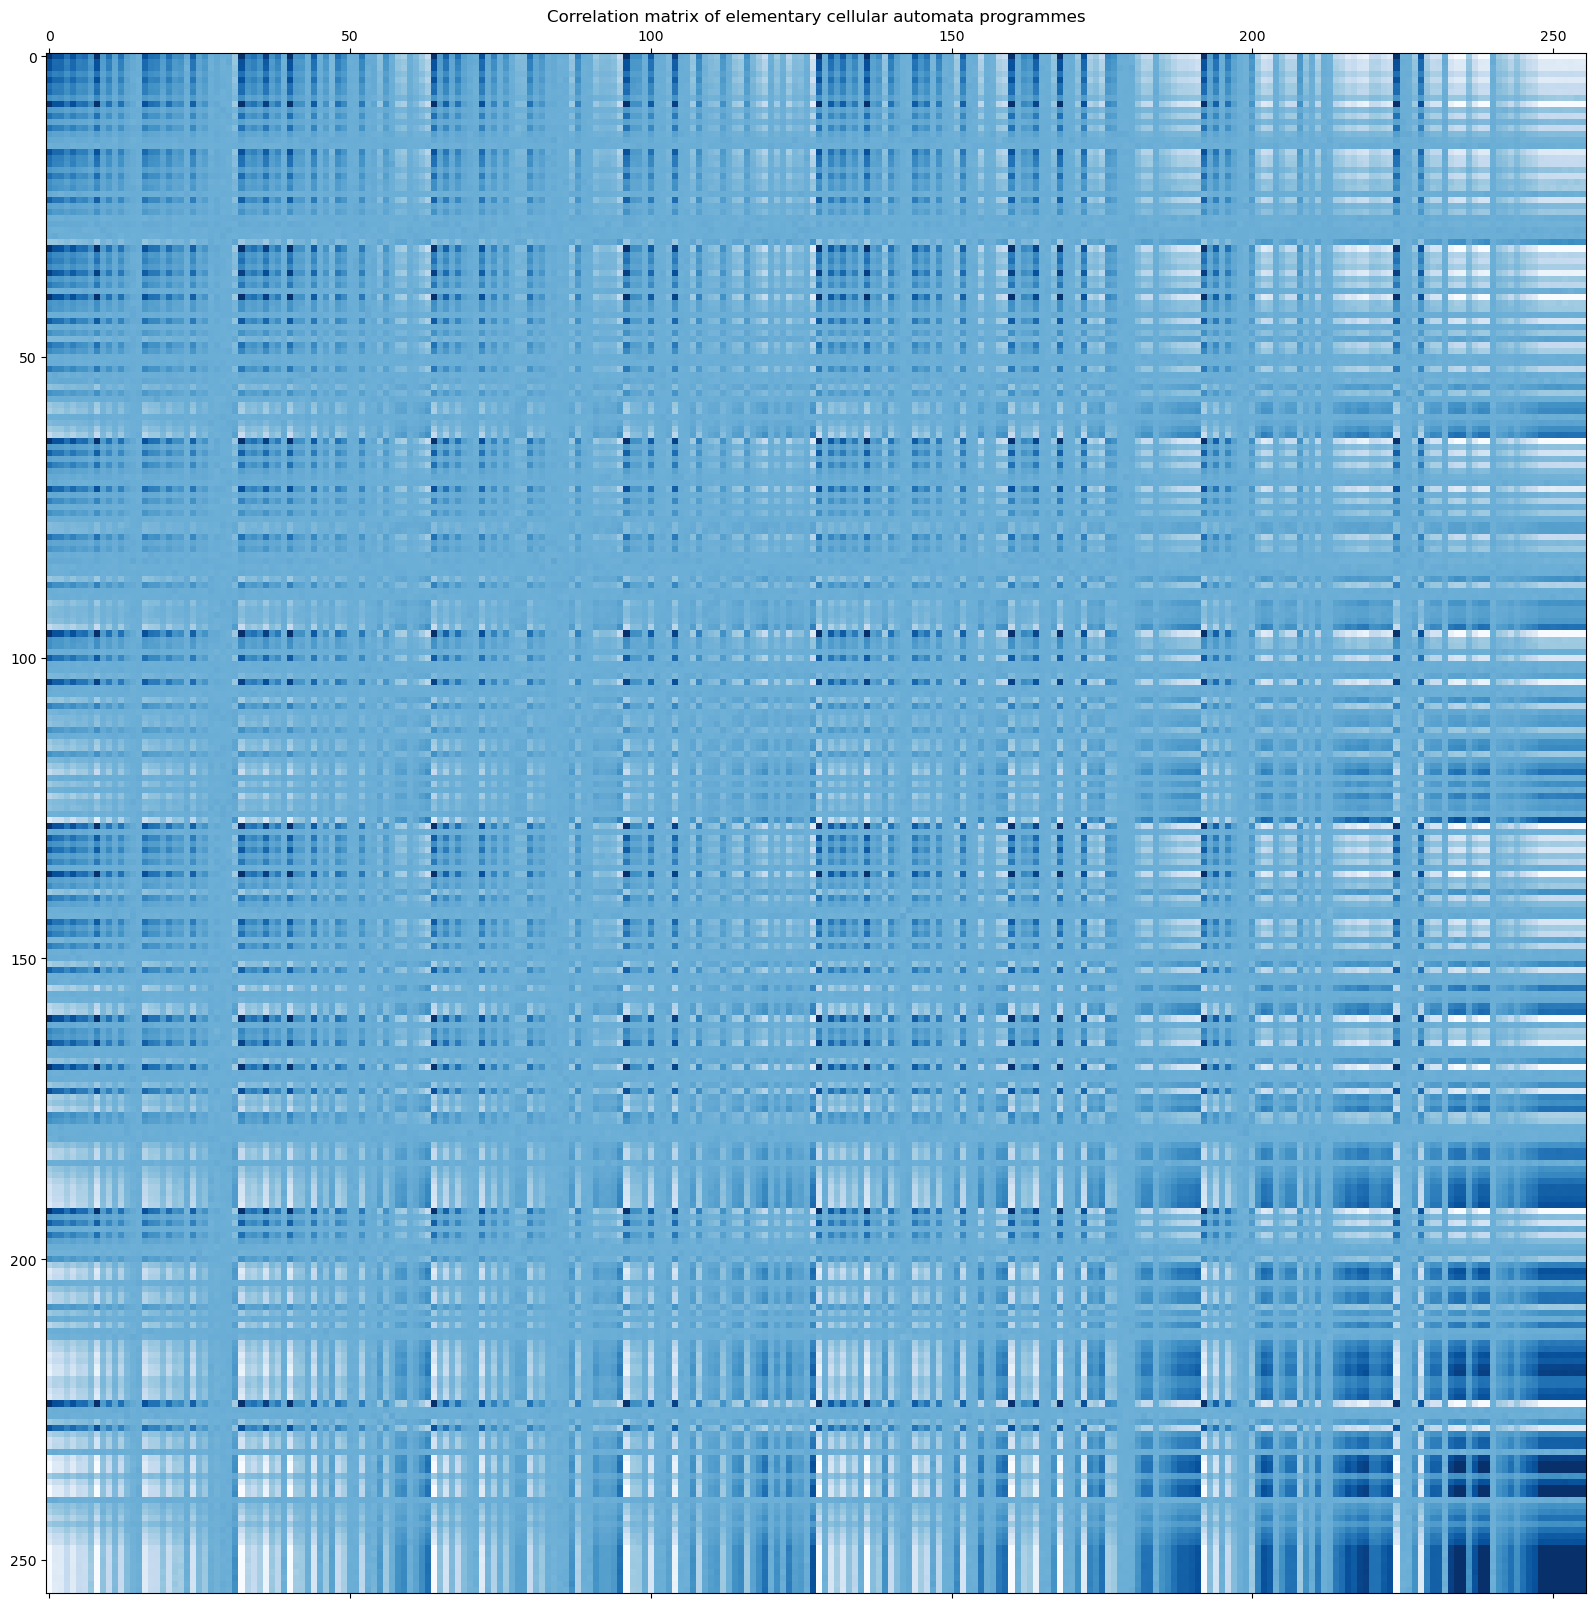

In [98]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,20)
#plt.rcParams.update({'font.size': 22})
plt.title('Correlation matrix of elementary cellular automata programmes')
ax.matshow(correlation_matrix, cmap=plt.cm.Blues)

In [99]:
correlation_matrix_copy = correlation_matrix

In [101]:
# Create a new file for the correlation matrix data, so that it is stored safe

#file_path = './correlation_matrix_.csv'

#np.savetxt(file_path, correlation_matrix, delimiter=',')

In [17]:
# Calculate the correation between two specified programmes

def find_corr_programmes(sample_number, data_size, time_steps, programme_1, programme_2):
    correlation = 0
    for i in tqdm(range(sample_number)):
        last_row = []
        cellular_automaton = cpl.init_random(data_size)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, programme_1))
        last_row.append(cellular_automaton[-1])
        cellular_automaton = cpl.init_random(data_size)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, programme_2))
        last_row.append(cellular_automaton[-1])

        corr = sum(x == y for x, y in zip(last_row[0], last_row[1]))
        correlation += corr

    correlation = correlation / sample_number
    
    return correlation

In [ ]:
print(find_corr_programmes(100, 100, 100, 248, 248))

In [ ]:
cellular_automaton = cpl.init_random(data_size)
cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, 219))
cpl.plot(cellular_automaton)

In [47]:
# Find a set of correlations between programmes

def find_corr_set(sample_number, data_size, time_steps, programme_list):

    correlation_matrix = np.zeros((len(programme_list), len(programme_list)))

    for i in range(len(programme_list)):
        for j in range(i, len(programme_list)):
            correlation_matrix[i][j] = find_corr_programmes(sample_number, data_size, time_steps, programme_list[i], programme_list[j])
            correlation_matrix[j][i] = correlation_matrix[i][j]

    return correlation_matrix

In [78]:
programme_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]

correlation_matrix = find_corr_set(sample_number = 100, data_size=100, time_steps = 100, programme_list=programme_list)

np.matrix.view(correlation_matrix)

100%|██████████| 100/100 [00:02<00:00, 42.21it/s]


array([[100.  ,  75.15,  76.68,  25.38, 100.  ,  26.55, 100.  ,  43.4 ,
         41.05,  50.48,  49.94,  50.34,   0.  ,   0.  ],
       [ 75.15,  61.84,  63.17,  38.19,  75.19,  37.67,  75.21,  46.17,
         45.05,  50.38,  49.55,  49.07,  24.9 ,  25.11],
       [ 76.68,  63.17,  64.8 ,  36.51,  77.07,  37.06,  76.38,  46.03,
         44.86,  50.12,  49.92,  49.29,  23.49,  23.57],
       [ 25.38,  38.19,  36.51,  62.4 ,  24.74,  62.59,  24.96,  53.48,
         53.86,  49.62,  49.43,  49.91,  74.87,  74.82],
       [100.  ,  75.19,  77.07,  24.74, 100.  ,  24.8 , 100.  ,  43.32,
         41.16,  50.12,  49.14,  49.19,   0.  ,   0.  ],
       [ 26.55,  37.67,  37.06,  62.59,  24.8 ,  63.63,  25.05,  53.09,
         54.78,  50.12,  48.69,  50.68,  74.18,  74.66],
       [100.  ,  75.21,  76.38,  24.96, 100.  ,  25.05, 100.  ,  43.69,
         41.44,  50.34,  50.19,  49.38,   0.  ,   0.  ],
       [ 43.4 ,  46.17,  46.03,  53.48,  43.32,  53.09,  43.69,  50.3 ,
         51.2 ,  49.74,  

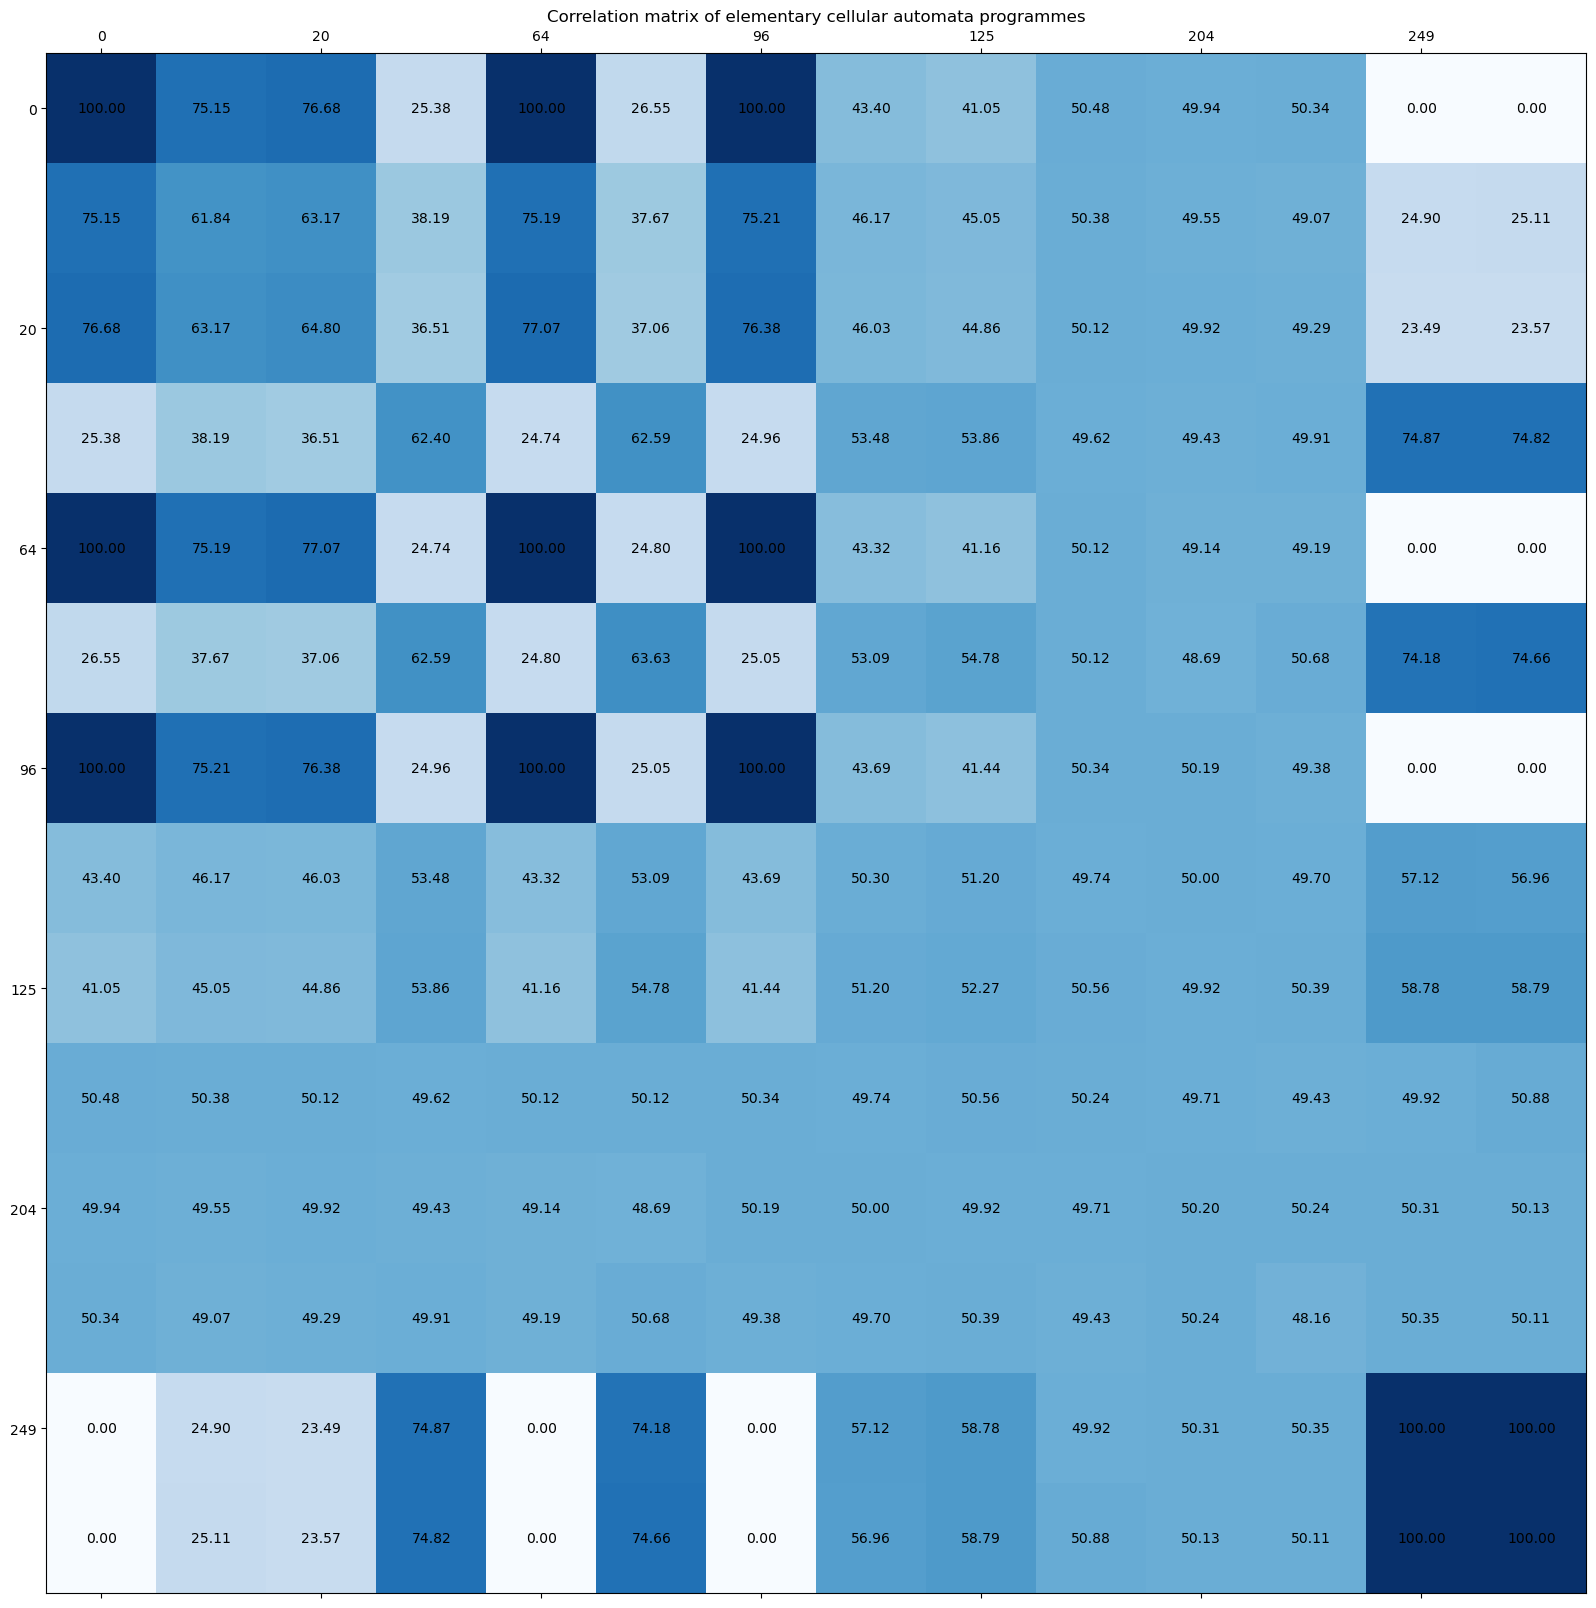

In [79]:
fig, ax = plt.subplots()
plt.title('Correlation matrix of elementary cellular automata programmes')

ax.set_xticks(np.arange(len(programme_list)))
#ax.set_xticks(np.arange(len(programme_list)) + 0.5)
ax.set_xticklabels(programme_list)

ax.set_yticks(np.arange(len(programme_list)))
#ax.set_yticks(np.arange(len(programme_list)) + 0.5)
ax.set_yticklabels(programme_list)

# Add text annotations for each square
for i in range(len(programme_list)):
    for j in range(len(programme_list)):
        ax.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center')

ax.matshow(correlation_matrix, cmap=plt.cm.Blues)
plt.show()

In [110]:
print(np.diagonal(correlation_matrix))

print(np.where(np.diagonal(correlation_matrix) == 100)[0])

[100.    77.25  78.51  62.34  78.12  61.29  63.86  52.61 100.    52.65
  62.16  50.07  62.62  51.46  49.07  50.23  78.47  63.16  61.38  52.78
  64.58  53.38  54.32  51.08  69.54  50.62  52.3   49.69  50.86  50.56
  49.94  53.37 100.    58.09  62.67  54.12  88.42  55.32  59.52  50.38
 100.    54.4   51.97  50.16  72.14  50.4   53.1   49.62  62.82  55.04
  50.46  49.68  59.75  49.5   49.88  50.93  53.45  50.88  53.5   54.71
  50.02  50.55  53.11  62.17 100.    51.9   69.78  51.11  62.2   48.86
  50.23  49.87  78.04  50.23  55.94  50.69  52.13  49.25  50.27  49.92
  63.26  51.38  54.16  49.55  53.35  50.    50.59  52.61  57.55  50.32
  49.74  52.75  50.7   51.44  50.55  62.6  100.    52.29  52.23  52.36
  72.5   49.74  49.96  50.18  87.94  49.89  50.87  53.02  57.54  49.92
  50.78  53.38  53.33  48.18  53.88  54.05  52.98  50.52  53.42  62.66
  50.34  53.64  50.04  56.95  51.97  51.05  51.57  78.05 100.    49.7
  72.68  53.25  72.83  52.4   59.87  49.61 100.    50.25  53.41  53.42
  62.74

In [105]:
programme_list = np.arange(0, 256, 1)

print([x for _, x in sorted(zip(np.diagonal(correlation_matrix), programme_list))]) # NOTE: This gives lowest autocorrelation first

[142, 213, 113, 143, 69, 14, 77, 199, 197, 240, 53, 83, 180, 135, 47, 195, 232, 51, 149, 27, 129, 90, 101, 166, 71, 54, 165, 105, 79, 109, 226, 30, 102, 85, 170, 179, 60, 122, 11, 204, 43, 103, 15, 70, 73, 161, 137, 156, 78, 89, 153, 120, 147, 169, 193, 39, 45, 50, 117, 210, 157, 61, 94, 29, 86, 225, 25, 150, 75, 92, 154, 110, 28, 106, 57, 55, 178, 125, 141, 23, 67, 212, 81, 93, 13, 126, 198, 184, 241, 65, 42, 124, 185, 76, 209, 98, 227, 97, 26, 99, 133, 174, 177, 181, 205, 7, 87, 200, 9, 91, 19, 171, 145, 244, 116, 107, 46, 62, 208, 131, 112, 163, 84, 31, 21, 111, 138, 118, 139, 56, 58, 121, 167, 114, 115, 35, 82, 236, 22, 151, 41, 59, 49, 176, 37, 242, 173, 74, 201, 162, 186, 229, 123, 108, 88, 33, 155, 38, 214, 52, 134, 211, 158, 148, 5, 18, 182, 183, 187, 146, 10, 63, 68, 243, 3, 245, 221, 196, 95, 12, 206, 119, 207, 34, 220, 140, 175, 48, 17, 80, 6, 159, 215, 20, 189, 24, 152, 194, 66, 230, 188, 231, 144, 203, 217, 222, 44, 246, 190, 100, 130, 132, 1, 202, 216, 223, 247, 72, 127, 

In [121]:
# (Possibly) uses hierarchical clustering to give me an ordering of the data

from scipy.cluster.hierarchy import linkage, dendrogram

programme_list = np.arange(0, 256, 1)

#linkage_matrix = linkage(correlation_matrix, method='average', metric='euclidean')
linkage_matrix = linkage(correlation_matrix, method='average', metric='seuclidean')

#dendrogram(linkage_matrix) #Plots the dendrogram
#order = np.argsort(linkage_matrix[:, 2])

dendrogram_info = dendrogram(linkage_matrix, no_plot=True)

# Retrieve the order of sets of data
order = dendrogram_info['leaves']

#print("Ordered sets of data:")
ordered_prog_list = []
for i in order:
    #print(f"Programme {programme_list[i]}")
    ordered_prog_list.append(programme_list[i])

print(f"Ordered list of programmes using Hierarchical clustering :", ordered_prog_list)

Ordered list of programmes using Hierarchical clustering : [233, 219, 238, 255, 248, 250, 234, 254, 249, 251, 252, 253, 235, 239, 247, 218, 246, 231, 127, 222, 190, 230, 216, 189, 237, 223, 188, 217, 202, 191, 203, 96, 192, 224, 40, 104, 32, 0, 8, 136, 168, 128, 64, 160, 18, 152, 80, 140, 196, 134, 108, 146, 34, 38, 176, 33, 148, 68, 48, 52, 12, 3, 17, 5, 10, 20, 172, 228, 132, 16, 2, 44, 130, 72, 144, 66, 194, 6, 24, 100, 1, 164, 4, 36, 123, 95, 183, 221, 201, 207, 155, 158, 63, 159, 211, 220, 243, 187, 175, 245, 206, 119, 214, 182, 215, 185, 111, 125, 115, 205, 242, 151, 229, 139, 241, 87, 186, 244, 59, 107, 181, 121, 173, 58, 167, 227, 31, 55, 118, 209, 92, 94, 114, 171, 174, 62, 91, 236, 143, 199, 226, 70, 84, 99, 141, 13, 57, 213, 83, 142, 28, 157, 86, 11, 14, 53, 113, 225, 85, 212, 93, 124, 184, 240, 147, 110, 103, 117, 126, 149, 179, 75, 198, 50, 101, 169, 135, 43, 102, 51, 156, 25, 232, 29, 30, 178, 71, 170, 195, 204, 54, 60, 210, 27, 150, 89, 109, 47, 165, 77, 154, 161, 105, 1

In [119]:
print(correlation_matrix[112][112])

53.33


In [126]:
# Calculate the average abs different in index between two lists

def avg_diff_index(list1, list2):
    # note that the two lists must be made up of permutations of the same set of objects, in this case integers from 0 to 255
    total_diff = 0
    for index, item in enumerate(list1):
        index2 = list2.index(item)
        diff = abs(index - index2)
        total_diff += diff
    return total_diff

In [127]:
list1 = [233, 219, 238, 255, 248, 250, 234, 254, 249, 251, 252, 253, 235, 239, 247, 218, 246, 231, 127, 222, 190, 230, 216, 189, 237, 223, 188, 217, 202, 191, 203, 96, 192, 224, 40, 104, 32, 0, 8, 136, 168, 128, 64, 160, 18, 152, 80, 140, 196, 134, 108, 146, 34, 38, 176, 33, 148, 68, 48, 52, 12, 3, 17, 5, 10, 20, 172, 228, 132, 16, 2, 44, 130, 72, 144, 66, 194, 6, 24, 100, 1, 164, 4, 36, 123, 95, 183, 221, 201, 207, 155, 158, 63, 159, 211, 220, 243, 187, 175, 245, 206, 119, 214, 182, 215, 185, 111, 125, 115, 205, 242, 151, 229, 139, 241, 87, 186, 244, 59, 107, 181, 121, 173, 58, 167, 227, 31, 55, 118, 209, 92, 94, 114, 171, 174, 62, 91, 236, 143, 199, 226, 70, 84, 99, 141, 13, 57, 213, 83, 142, 28, 157, 86, 11, 14, 53, 113, 225, 85, 212, 93, 124, 184, 240, 147, 110, 103, 117, 126, 149, 179, 75, 198, 50, 101, 169, 135, 43, 102, 51, 156, 25, 232, 29, 30, 178, 71, 170, 195, 204, 54, 60, 210, 27, 150, 89, 109, 47, 165, 77, 154, 161, 105, 15, 90, 23, 122, 45, 166, 153, 106, 129, 39, 180, 61, 79, 78, 120, 56, 197, 73, 193, 42, 98, 35, 22, 74, 65, 67, 69, 81, 133, 9, 137, 163, 116, 21, 49, 82, 41, 145, 7, 208, 76, 112, 26, 19, 37, 138, 131, 177, 88, 162, 200, 46, 97]
list2 = [96, 0, 160, 32, 224, 192, 8, 136, 40, 168, 64, 128, 164, 36, 104, 6, 20, 18, 146, 5, 17, 196, 3, 48, 10, 12, 34, 68, 80, 140, 134, 148, 38, 52, 33, 108, 74, 88, 172, 228, 4, 72, 1, 2, 16, 44, 100, 144, 130, 132, 194, 66, 24, 152, 41, 97, 7, 21, 37, 26, 82, 98, 56, 200, 116, 138, 208, 163, 76, 42, 46, 112, 177, 22, 131, 145, 35, 49, 162, 176, 19, 133, 9, 65, 11, 81, 25, 67, 141, 13, 69, 197, 137, 193, 147, 143, 157, 109, 199, 213, 126, 57, 226, 129, 161, 23, 232, 184, 122, 142, 83, 27, 39, 71, 102, 99, 86, 204, 153, 180, 210, 105, 212, 15, 53, 50, 60, 85, 89, 225, 29, 149, 169, 45, 156, 106, 165, 150, 51, 120, 135, 154, 30, 75, 198, 178, 179, 43, 90, 101, 170, 166, 77, 113, 195, 240, 54, 70, 73, 28, 14, 84, 87, 31, 107, 121, 181, 91, 167, 236, 185, 227, 209, 244, 139, 241, 58, 174, 205, 114, 171, 151, 62, 118, 59, 115, 186, 242, 55, 111, 94, 125, 47, 61, 103, 117, 110, 124, 93, 92, 78, 79, 248, 250, 252, 234, 254, 251, 239, 235, 255, 249, 238, 253, 218, 219, 233, 159, 215, 182, 183, 95, 119, 207, 63, 220, 206, 175, 221, 243, 187, 245, 158, 214, 155, 211, 123, 201, 173, 229, 237, 127, 216, 223, 247, 191, 202, 217, 222, 190, 203, 246, 230, 189, 188, 231]

In [131]:
total_diff = avg_diff_index(list1, list2)
print(total_diff)
print(f"Average difference = ", total_diff/256) # Due to complete randomness the expected average index change would be 256/2 = 128

23290
Average difference =  90.9765625
